##Benson Challenges

#### Challenge 1

- Open up a new IPython notebook
- Download a few MTA turnstile data files
- Open up a file, use csv reader to read it, make a python dict where
  there is a key for each (C/A, UNIT, SCP, STATION). These are the
  first four columns. The value for this key should be a list of
  lists. Each list in the list is the rest of the columns in a
  row. For example, one key-value pair should look like


{    ('A002','R051','02-00-00','LEXINGTON AVE'):
[
['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'],
['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'],
['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'],
...
]
}

In [1]:
 from datetime import datetime, timedelta

from pprint import pprint
import pandas as pd


def get_data(start,end):

    """
    Downloads data from online MTA data source
    It loops through all recent data, and appends it to a single csv datafile
    """

    end_date = datetime.strptime(end, '%y%m%d')
    current_date = datetime.strptime(start, '%y%m%d')
    base_link = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    df = pd.read_csv(base_link+current_date.strftime('%y%m%d')+'.txt')
    total = len(df)
    while(current_date < end_date):
        current_date = current_date+timedelta(days=7)
        link = base_link+current_date.strftime('%y%m%d')+'.txt'
        new_df = pd.read_csv(link)
        total += len(new_df)
        print link, total
        df = df.append(new_df, ignore_index=True)

    return df
df=get_data('150905','150919')

http://web.mta.info/developers/data/nyct/turnstile/turnstile_150912.txt 385032
http://web.mta.info/developers/data/nyct/turnstile/turnstile_150919.txt 581937


In [2]:
##add Day and Month Column
data=df
data['DAY'] = data['DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%a'))
data['DAY_NUM'] = data['DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%w'))
data['MONTH'] = data['DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%m'))

##Remove the entries and exits collumation factor by subtracking the previous value
data = data.rename(columns={'EXITS                                                               ': 'EXITS'})
data['TIMEFRAME_ENTRIES']  = data['ENTRIES'] - data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES'].shift(1)
data['TIMEFRAME_EXITS']= data['EXITS'] - data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['EXITS'].shift(1)

##Remove unreasonable values from the entries and exit columns
data = data[(data['TIMEFRAME_ENTRIES'] >= 0) &(data['TIMEFRAME_ENTRIES'] <= 5000)]
data = data[(data['TIMEFRAME_EXITS'] >= 0) & (data['TIMEFRAME_EXITS'] <= 5000)]

##save file to data pickle file
data.to_pickle('benson_dataframe.p')


In [3]:
#create dic of turnstile grouped by ['C/A','UNIT','SCP','STATION']
dic={}
for key, value in data.groupby(['C/A','UNIT','SCP','STATION']):
    dic[key]=value[[x for x in value.columns.tolist() if x not in ['C/A','UNIT','SCP','STATION']]].values.tolist()

#### Challenge 2

- Let's turn this into a time series.

 For each key (basically the control area, unit, device address and
 station of a specific turnstile), have a list again, but let the list
 be comprised of just the point in time and the count of entries.

This basically means keeping only the date, time, and entries fields
in each list. You can convert the date and time into datetime objects
-- That is a python class that represents a point in time. You can
combine the date and time fields into a string and use the
[dateutil](https://labix.org/python-dateutil) module to convert it
into a datetime object. For an example check
[this StackOverflow question](http://stackoverflow.com/questions/23385003/attributeerror-when-using-import-dateutil-and-dateutil-parser-parse-but-no).

Your new dict should look something like

{    ('A002','R051','02-00-00','LEXINGTON AVE'):
[
[datetime.datetime(2013, 3, 2, 3, 0), 3788],
[datetime.datetime(2013, 3, 2, 7, 0), 2585],
[datetime.datetime(2013, 3, 2, 12, 0), 10653],
[datetime.datetime(2013, 3, 2, 17, 0), 11016],
[datetime.datetime(2013, 3, 2, 23, 0), 10666],
[datetime.datetime(2013, 3, 3, 3, 0), 10814],
[datetime.datetime(2013, 3, 3, 7, 0), 10229],
...
],
....
}

In [4]:
for key in dic:
    lst=[]
    for i in xrange(1,len(dic[key])):
        lst.append([datetime.strptime(dic[key][i][2]+" "+dic[key][i][3], '%m/%d/%Y %H:%M:%S'),dic[key][i][-2]])
    dic[key]=lst

#### Challenge 3

- These counts are for every n hours. (What is n?) We want total daily
  entries.

Now make it that we again have the same keys, but now we have a single
value for a single day, which is the total number of passengers that
entered through this turnstile on this day.




In [5]:
#N is about every 4 hours but not always data is dirty.
for key in dic:
    dicDay={}
    for time, count in dic[key]:
        time=time.date()
        if time in dicDay:
            dicDay[time]+=count
        else:
            dicDay[time]=count
    dic[key]=sorted([(x,dicDay[x]) for x in dicDay])


#### Challenge 4

We will plot the daily time series for a turnstile.

In ipython notebook, add this to the beginning of your next cell:

    %matplotlib inline

This will make your matplotlib graphs integrate nicely with the
notebook. To plot the time series, import matplotlib with

    import matplotlib.pyplot as plt

Take the list of [(date1, count1), (date2, count2), ...], for the
turnstile and turn it into two lists:
dates and counts. This should plot it:

    plt.figure(figsize=(10,3))
    plt.plot(dates,counts)




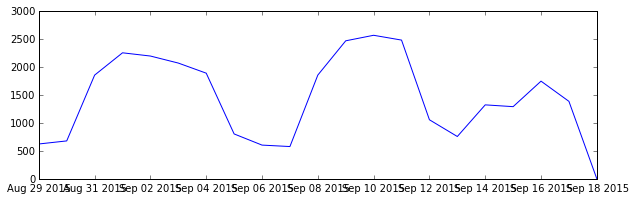

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
dates=[item[0] for item in dic[dic.keys()[0]]]
counts=[item[1] for item in dic[dic.keys()[0]]]
plt.figure(figsize=(10,3))
plt.plot(dates,counts)

#### Challenge 5

- So far we've been operating on a single turnstile level, let's
  combine turnstiles in the same ControlArea/Unit/Station combo. There
  are some ControlArea/Unit/Station groups that have a single
  turnstile, but most have multiple turnstilea-- same value for the
  C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each
ControlArea/UNIT/STATION combo, for each day, add the counts from each
turnstile belonging to that combo.

In [7]:
ch5={}
for key, value in data.groupby(['C/A', 'UNIT', 'STATION']):
    ch5[key]=[(date,x['TIMEFRAME_ENTRIES'].sum()) for date, x in value.groupby('DATE')]

#### Challenge 6

Similarly, combine everything in each station, and come up with a time
series of `[(date1, count1),(date2,count2),...]` type of time series
for each STATION, by adding up all the turnstiles in a station.

In [8]:
ch6={}
for key, value in data.groupby(['STATION']):
    ch6[key]=[(datetime.strptime(date,'%m/%d/%Y'),x['TIMEFRAME_ENTRIES'].sum()) for date, x in value.groupby('DATE')]

#### Challenge 7

Plot the time series for a station.

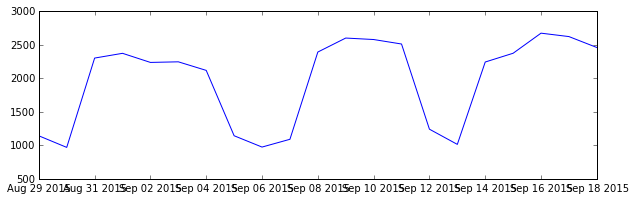

In [9]:
x, y =zip(*ch6[key])
plt.figure(figsize=(10,3))
plt.plot(x,y)

#### Challenge 8

- Make one list of counts for **one** week for one station. Monday's
count, Tuesday's count, etc. so it's a list of 7 counts.
Make the same list for another week, and another week, and another
week.
`plt.plot(week_count_list)` for every `week_count_list` you created
this way. You should get a rainbow plot of weekly commute numbers on
top of each other.

In [10]:
week_count_list=[]
dic={}
for day in ch6['ZEREGA AVE']:
    key=day[0].strftime('%W %Y')
    if key not in dic:
        dic[key]=[(day[0].strftime('%w'),day[1])]
    else:
        dic[key]+=[(day[0].strftime('%w'),day[1])]
##change dic to list
for key in dic:
    week_count_list.append(dic[key])

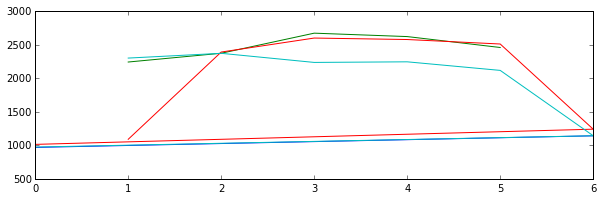

In [11]:
#graph all the weeks on one chart
plt.figure(figsize=(10,3))
for week in week_count_list:
    x, y = zip(*week)
    plt.plot(x,y)

#### Challenge 9

- Over multiple weeks, sum total ridership for each station and sort
  them, so you can find out the stations with the highest traffic
  during the time you investigate

In [12]:
data.groupby(['STATION']).sum().sort('TIMEFRAME_ENTRIES', ascending=False).head(10)['TIMEFRAME_ENTRIES']

STATION
34 ST-PENN STA     3006697
42 ST-GRD CNTRL    2603232
34 ST-HERALD SQ    2087479
14 ST-UNION SQ     1962174
86 ST              1888202
42 ST-TIMES SQ     1834433
42 ST-PA BUS TE    1655014
125 ST             1354916
96 ST              1343708
FULTON ST          1317473
Name: TIMEFRAME_ENTRIES, dtype: float64

#### Challenge 10

- Make a single list of these total ridership values and plot it with

    plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among
different stations.

This should show you that most stations have a small traffic, and the
histogram bins for large traffic volumes have small bars.

*Additional Hint*:

If you want to see which stations take the meat of the traffic, you
can sort the total ridership counts and make a `plt.bar` graph. For
this, you want to have two lists: the indices of each bar, and the
values. The indices can just be `0,1,2,3,...`, so you can do

    indices = range(len(total_ridership_values))
    plt.bar(indices, total_ridership_values)

(array([ 295.,   54.,   19.,    4.,    6.,    1.,    4.,    0.,    1.,    1.]),
 array([    5607.,   305716.,   605825.,   905934.,  1206043.,  1506152.,
         1806261.,  2106370.,  2406479.,  2706588.,  3006697.]),
 <a list of 10 Patch objects>)

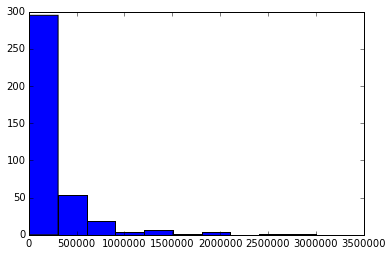

In [21]:
total_ridership_counts=data.groupby(['STATION']).sum()['TIMEFRAME_ENTRIES'].tolist()
plt.hist(total_ridership_counts)